# F1 Aerodynamics: Complete Complexity & Chaos Analysis

This notebook performs comprehensive flow analysis including:
- **Velocity & Pressure fields**
- **Vorticity and flow structures**
- **Energy spectra** (Kolmogorov cascade)
- **Chaos detection** (Lyapunov exponents, bifurcations)
- **Phase space reconstruction**
- **Dynamical regime classification**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import numpy as np
from lbm_core import LBMSolver
from boundaries import TunnelBoundaries
from analysis import plot_complexity_dashboard
from aerodynamics import calculate_lift_drag, check_ground_effect
import json
from datetime import datetime
from pathlib import Path
from scipy import signal, stats
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

## Configuration

In [2]:
# --- BASE CONFIGURATION ---
NX, NY = 500, 200
GROUND_TYPE = "no_slip"
SIMULATION_STEPS = 8000  # Longer for chaos analysis
CHECKPOINT_INTERVAL = 100
SPECTRUM_INTERVAL = 500

# --- PARAMETER SWEEP ---
# Option 1: Bifurcation analysis (vary one parameter densely)
USE_BIFURCATION_MODE = True
if USE_BIFURCATION_MODE:
    RIDE_HEIGHTS = [19]  # Fixed
    REYNOLDS_NUMBERS = np.linspace(1000, 25000, 25)  # Dense sweep for bifurcations
else:
    # Option 2: Multi-parameter exploration
    RIDE_HEIGHTS = [10, 19, 35]
    REYNOLDS_NUMBERS = [1000, 5000, 10000, 20000]

# --- OUTPUT ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = Path(f"complete_analysis_{timestamp}")
results_dir.mkdir(exist_ok=True)

(results_dir / "snapshots").mkdir(exist_ok=True)
(results_dir / "pressure").mkdir(exist_ok=True)
(results_dir / "vorticity").mkdir(exist_ok=True)
(results_dir / "spectra").mkdir(exist_ok=True)
(results_dir / "chaos").mkdir(exist_ok=True)
(results_dir / "phase_space").mkdir(exist_ok=True)
(results_dir / "timeseries").mkdir(exist_ok=True)

print(f"Results → {results_dir}")
print(f"Total simulations: {len(RIDE_HEIGHTS) * len(REYNOLDS_NUMBERS)}")
print(f"Mode: {'Bifurcation Analysis' if USE_BIFURCATION_MODE else 'Multi-Parameter Exploration'}")

Results → complete_analysis_20260126_212404
Total simulations: 25
Mode: Bifurcation Analysis


## Analysis Tools

In [3]:
class CompleteFlowAnalyzer:
    """Unified analyzer: phenomena + spectra + chaos"""
    
    def __init__(self, ride_height, reynolds, nx, ny):
        self.ride_height = ride_height
        self.reynolds = reynolds
        self.nx = nx
        self.ny = ny
        
        # Flow field storage
        self.velocity_snapshots = []
        self.vorticity_snapshots = []
        self.pressure_snapshots = []
        self.snapshot_steps = []
        
        # Time series
        self.lift_history = []
        self.drag_history = []
        self.step_history = []
        self.max_velocity_history = []
        self.vorticity_magnitude = []
        
        # Spectral data
        self.energy_spectra_1d = []
        self.energy_spectra_2d = []
        self.spectrum_steps = []
        
        # Chaos metrics
        self.lyapunov_exponent = None
        self.correlation_dimension = None
        self.chaos_test_result = None
        self.attractor_type = None
        self.embedding_dim = None
        self.embedding_delay = None
        
        # Phenomena flags
        self.vortex_shedding = False
        self.shedding_frequency = None
        self.turbulence_intensity = None
        self.kolmogorov_slope = None
    
    # ===== FIELD CALCULATIONS =====
    
    def calculate_pressure_field(self, solver, mask):
        """Pressure from LBM density"""
        rho = np.sum(solver.f, axis=2)
        pressure = (rho - 1.0) / (0.5 * 1.0 * solver.u_inlet**2)
        pressure[mask] = np.nan
        return pressure
    
    def calculate_vorticity(self, velocity_field, mask):
        """Vorticity ω = ∂v/∂x - ∂u/∂y"""
        u = velocity_field[:,:,0]
        v = velocity_field[:,:,1]
        du_dy = np.gradient(u, axis=0)
        dv_dx = np.gradient(v, axis=1)
        vorticity = dv_dx - du_dy
        vorticity[mask] = np.nan
        return vorticity
    
    # ===== SPECTRAL ANALYSIS =====
    
    def compute_energy_spectrum(self, velocity_field, mask):
        """Turbulent kinetic energy spectrum E(k)"""
        u = velocity_field[:,:,0].copy()
        v = velocity_field[:,:,1].copy()
        u[mask] = 0
        v[mask] = 0
        
        u_fft = np.fft.fft2(u)
        v_fft = np.fft.fft2(v)
        energy_2d = 0.5 * (np.abs(u_fft)**2 + np.abs(v_fft)**2)
        
        kx = np.fft.fftfreq(self.nx) * self.nx
        ky = np.fft.fftfreq(self.ny) * self.ny
        kx_grid, ky_grid = np.meshgrid(kx, ky)
        k_mag = np.sqrt(kx_grid**2 + ky_grid**2)
        
        energy_2d_shifted = np.fft.fftshift(energy_2d)
        
        # Radial average
        k_bins = np.arange(0.5, min(self.nx, self.ny)//2, 1.0)
        k_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
        energy_1d = np.zeros(len(k_centers))
        
        for i, k_center in enumerate(k_centers):
            mask_ring = (k_mag >= k_bins[i]) & (k_mag < k_bins[i+1])
            if np.any(mask_ring):
                energy_1d[i] = np.mean(energy_2d[mask_ring])
        
        return k_centers, energy_1d, energy_2d_shifted
    
    def fit_kolmogorov_slope(self, k, E_k):
        """Fit power law to inertial range"""
        valid = (E_k > 0) & (k > 1)
        if np.sum(valid) < 5:
            return None
        
        k_valid = k[valid]
        E_valid = E_k[valid]
        log_k = np.log10(k_valid)
        log_E = np.log10(E_valid)
        
        mid_start = len(log_k) // 4
        mid_end = 3 * len(log_k) // 4
        if mid_end <= mid_start + 2:
            return None
        
        coeffs = np.polyfit(log_k[mid_start:mid_end], log_E[mid_start:mid_end], 1)
        return coeffs[0]
    
    # ===== CHAOS ANALYSIS =====
    
    def find_embedding_parameters(self, signal_data):
        """Find optimal embedding via AMI"""
        max_delay = min(100, len(signal_data) // 10)
        delays = np.arange(1, max_delay)
        ami = np.zeros(len(delays))
        
        for i, delay in enumerate(delays):
            ami[i] = self._mutual_information(signal_data[:-delay], signal_data[delay:])
        
        ami_mins = signal.argrelextrema(ami, np.less)[0]
        if len(ami_mins) > 0:
            return 3, delays[ami_mins[0]]
        return 3, delays[np.argmin(ami)] if len(ami) > 0 else 10
    
    def _mutual_information(self, x, y, bins=20):
        """Compute MI between signals"""
        hist_xy, _, _ = np.histogram2d(x, y, bins=bins)
        hist_x, _ = np.histogram(x, bins=bins)
        hist_y, _ = np.histogram(y, bins=bins)
        
        p_xy = hist_xy / np.sum(hist_xy)
        p_x = hist_x / np.sum(hist_x)
        p_y = hist_y / np.sum(hist_y)
        
        mi = 0
        for i in range(bins):
            for j in range(bins):
                if p_xy[i,j] > 0:
                    mi += p_xy[i,j] * np.log(p_xy[i,j] / (p_x[i] * p_y[j] + 1e-10))
        return mi
    
    def reconstruct_phase_space(self, signal_data, dim, delay):
        """Time-delay embedding"""
        n_vectors = len(signal_data) - (dim - 1) * delay
        embedded = np.zeros((n_vectors, dim))
        for i in range(dim):
            embedded[:, i] = signal_data[i*delay : i*delay + n_vectors]
        return embedded
    
    def largest_lyapunov_exponent(self, signal_data, dt=1.0):
        """Estimate largest Lyapunov exponent"""
        dim, delay = self.find_embedding_parameters(signal_data)
        embedded = self.reconstruct_phase_space(signal_data, dim, delay)
        
        n_points = len(embedded)
        max_iter = min(100, n_points // 10)
        
        distances = squareform(pdist(embedded))
        np.fill_diagonal(distances, np.inf)
        
        divergence = []
        for i in range(max_iter):
            valid_indices = np.where(np.arange(n_points) + i < n_points)[0]
            if len(valid_indices) < n_points // 2:
                break
            
            nn_idx = np.argmin(distances[valid_indices], axis=1)
            separations = []
            for j, idx in enumerate(valid_indices):
                if idx + i < n_points and nn_idx[j] + i < n_points:
                    sep = np.linalg.norm(embedded[idx + i] - embedded[nn_idx[j] + i])
                    if sep > 0:
                        separations.append(np.log(sep))
            
            if len(separations) > 0:
                divergence.append(np.mean(separations))
        
        if len(divergence) > 10:
            x = np.arange(len(divergence)) * dt
            coeffs = np.polyfit(x[:len(divergence)//2], divergence[:len(divergence)//2], 1)
            return coeffs[0], dim, delay
        return None, dim, delay
    
    def zero_one_test(self, signal_data):
        """0-1 test for chaos"""
        n = len(signal_data)
        c = np.pi / 5
        phi = np.cumsum(signal_data * np.cos(c * np.arange(n)))
        
        M = np.zeros(n // 10)
        for j in range(1, len(M)):
            M[j] = np.mean((phi[j:] - phi[:-j])**2)
        
        n_fit = np.arange(len(M))
        valid = M > 0
        if np.sum(valid) > 5:
            K = np.polyfit(n_fit[valid], M[valid], 1)[0]
            return K
        return None
    
    def classify_attractor(self):
        """Classify attractor type"""
        if self.lyapunov_exponent is not None and self.lyapunov_exponent > 0.01:
            return "Strange Attractor (Chaotic)"
        elif self.lyapunov_exponent is not None and abs(self.lyapunov_exponent) < 0.001:
            freqs, psd = signal.periodogram(self.lift_history, fs=1.0)
            peaks, _ = signal.find_peaks(psd, height=np.max(psd)*0.1)
            
            if len(peaks) == 1:
                return "Limit Cycle (Periodic)"
            elif len(peaks) > 1:
                return "Torus (Quasi-periodic)"
            else:
                return "Fixed Point (Steady)"
        return "Transitional"
    
    # ===== DATA COLLECTION =====
    
    def add_snapshot(self, step, solver, bounds_mask):
        """Capture full flow state"""
        self.snapshot_steps.append(step)
        
        # Velocity
        v_mag = np.sqrt(solver.u[:,:,0]**2 + solver.u[:,:,1]**2)
        v_mag[bounds_mask] = np.nan
        self.velocity_snapshots.append(v_mag.copy())
        
        # Vorticity
        vorticity = self.calculate_vorticity(solver.u, bounds_mask)
        self.vorticity_snapshots.append(vorticity)
        self.vorticity_magnitude.append(np.nansum(np.abs(vorticity)))
        
        # Pressure
        pressure = self.calculate_pressure_field(solver, bounds_mask)
        self.pressure_snapshots.append(pressure)
    
    def add_spectrum(self, step, solver, bounds_mask):
        """Compute energy spectrum"""
        k, E_k, E_2d = self.compute_energy_spectrum(solver.u, bounds_mask)
        self.spectrum_steps.append(step)
        self.energy_spectra_1d.append((k, E_k))
        self.energy_spectra_2d.append(E_2d)
    
    def add_step_data(self, step, lift, drag, max_vel):
        """Record time series"""
        self.step_history.append(step)
        self.lift_history.append(lift)
        self.drag_history.append(drag)
        self.max_velocity_history.append(max_vel)
    
    # ===== ANALYSIS =====
    
    def analyze_all(self):
        """Run complete analysis pipeline"""
        print(f"  Analyzing Re={self.reynolds}, RH={self.ride_height}...")
        
        # Use second half for steady-state
        steady_start = len(self.lift_history) // 2
        lift_steady = np.array(self.lift_history[steady_start:])
        
        # Vortex shedding
        if len(lift_steady) > 500:
            lift_signal = lift_steady - np.mean(lift_steady)
            fft = np.fft.fft(lift_signal)
            freqs = np.fft.fftfreq(len(lift_signal))
            power = np.abs(fft)**2
            
            positive_freqs = freqs[1:len(freqs)//2]
            positive_power = power[1:len(power)//2]
            
            if len(positive_power) > 0:
                peak_idx = np.argmax(positive_power)
                if positive_power[peak_idx] > 5 * np.mean(positive_power):
                    self.vortex_shedding = True
                    self.shedding_frequency = abs(positive_freqs[peak_idx])
        
        # Turbulence intensity
        if len(self.max_velocity_history) > 100:
            vel_array = np.array(self.max_velocity_history[-500:])
            mean_vel = np.mean(vel_array)
            if mean_vel > 0:
                self.turbulence_intensity = np.std(vel_array) / mean_vel
        
        # Energy cascade
        if len(self.energy_spectra_1d) > 0:
            k, E_k = self.energy_spectra_1d[-1]
            self.kolmogorov_slope = self.fit_kolmogorov_slope(k, E_k)
        
        # Chaos metrics
        if len(lift_steady) > 200:
            lyap, dim, delay = self.largest_lyapunov_exponent(lift_steady, dt=1.0)
            self.lyapunov_exponent = lyap
            self.embedding_dim = dim
            self.embedding_delay = delay
            self.chaos_test_result = self.zero_one_test(lift_steady)
            self.attractor_type = self.classify_attractor()
        
        print(f"    Lyapunov: {self.lyapunov_exponent:.6f}" if self.lyapunov_exponent else "    Lyapunov: N/A")
        print(f"    Attractor: {self.attractor_type}")
        print(f"    Vortex shedding: {'YES' if self.vortex_shedding else 'NO'}")
        if self.kolmogorov_slope:
            print(f"    Energy cascade slope: {self.kolmogorov_slope:.3f}")
    
    def save(self, base_dir):
        """Save all data"""
        base_dir = Path(base_dir)
        prefix = f"rh{self.ride_height:.0f}_re{self.reynolds:.0f}"
        
        # Summary
        summary = {
            'ride_height': float(self.ride_height),
            'reynolds': float(self.reynolds),
            'lyapunov': float(self.lyapunov_exponent) if self.lyapunov_exponent else None,
            'attractor_type': self.attractor_type,
            'vortex_shedding': self.vortex_shedding,
            'shedding_frequency': float(self.shedding_frequency) if self.shedding_frequency else None,
            'turbulence_intensity': float(self.turbulence_intensity) if self.turbulence_intensity else None,
            'kolmogorov_slope': float(self.kolmogorov_slope) if self.kolmogorov_slope else None,
        }
        
        with open(base_dir / "chaos" / f"{prefix}_summary.json", 'w') as f:
            json.dump(summary, f, indent=2)
        
        # Time series
        np.savez_compressed(
            base_dir / "timeseries" / f"{prefix}_timeseries.npz",
            steps=self.step_history,
            lift=self.lift_history,
            drag=self.drag_history
        )
        
        # Snapshots
        np.savez_compressed(
            base_dir / "snapshots" / f"{prefix}_snapshots.npz",
            velocity=np.array(self.velocity_snapshots),
            vorticity=np.array(self.vorticity_snapshots),
            pressure=np.array(self.pressure_snapshots),
            steps=self.snapshot_steps
        )
        
        # Spectra
        if len(self.energy_spectra_1d) > 0:
            np.savez_compressed(
                base_dir / "spectra" / f"{prefix}_spectra.npz",
                k_values=[k for k, _ in self.energy_spectra_1d],
                E_k_values=[E for _, E in self.energy_spectra_1d]
            )


def create_geometry(bounds, ride_height):
    """Create F1 car geometry"""
    bounds.add_ground(type=GROUND_TYPE)
    bounds.add_f1_wing_proxy(x_pos=150, height=ride_height, length=60, slope=0.45)
    bounds.add_rectangular_obstacle(x_start=210, y_start=ride_height + 1, length=120, height=20)
    bounds.add_reverse_triangle(x_pos=240, height=ride_height + 20, length=90, slope=2/9)
    bounds.add_f1_wing_proxy(x_pos=300, height=ride_height + 30, length=30, slope=0.2)

## Run Complete Analysis

In [4]:
all_analyzers = []

total_sims = len(RIDE_HEIGHTS) * len(REYNOLDS_NUMBERS)
sim_counter = 0

print("="*70)
print("COMPLETE FLOW ANALYSIS")
print("="*70)

for reynolds in REYNOLDS_NUMBERS:
    for ride_height in RIDE_HEIGHTS:
        sim_counter += 1
        print(f"\n[{sim_counter}/{total_sims}] Re={reynolds:.0f}, RH={ride_height:.1f}")
        print("-" * 70)
        
        analyzer = CompleteFlowAnalyzer(ride_height, reynolds, NX, NY)
        
        solver = LBMSolver(NX, NY, int(reynolds), u_inlet=0.1)
        bounds = TunnelBoundaries(NX, NY)
        create_geometry(bounds, ride_height)
        
        relevant_x_start = 145
        relevant_x_end = 335
        relevant_y_start = 5
        relevant_y_end = min(75, int(ride_height) + 60)
        
        print(f"  Running {SIMULATION_STEPS} steps...")
        for step in range(SIMULATION_STEPS):
            solver.collide_and_stream(bounds.mask)
            bounds.apply_inlet_outlet(solver)
            
            # Sample frequently for chaos analysis
            if step % 5 == 0:
                fx, fy = calculate_lift_drag(
                    solver, bounds,
                    x_start=relevant_x_start, x_end=relevant_x_end,
                    y_start=relevant_y_start, y_end=relevant_y_end
                )
                max_vel = np.max(np.sqrt(solver.u[:,:,0]**2 + solver.u[:,:,1]**2))
                analyzer.add_step_data(step, fy, fx, max_vel)
            
            # Snapshots
            if step % CHECKPOINT_INTERVAL == 0 or step == SIMULATION_STEPS - 1:
                analyzer.add_snapshot(step, solver, bounds.mask)
            
            # Spectra
            if step % SPECTRUM_INTERVAL == 0 and step > 0:
                analyzer.add_spectrum(step, solver, bounds.mask)
        
        # Final spectrum
        analyzer.add_spectrum(SIMULATION_STEPS, solver, bounds.mask)
        
        # Analyze everything
        analyzer.analyze_all()
        analyzer.save(results_dir)
        all_analyzers.append(analyzer)

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)

COMPLETE FLOW ANALYSIS

[1/25] Re=1000, RH=19.0
----------------------------------------------------------------------
  Running 8000 steps...
  Analyzing Re=1000.0, RH=19...
    Lyapunov: 0.004575
    Attractor: Transitional
    Vortex shedding: YES
    Energy cascade slope: -3.633

[2/25] Re=2000, RH=19.0
----------------------------------------------------------------------
  Running 8000 steps...
  Analyzing Re=2000.0, RH=19...
    Lyapunov: 0.000139
    Attractor: Torus (Quasi-periodic)
    Vortex shedding: YES
    Energy cascade slope: -3.520

[3/25] Re=3000, RH=19.0
----------------------------------------------------------------------
  Running 8000 steps...
  Analyzing Re=3000.0, RH=19...
    Lyapunov: 0.000674
    Attractor: Torus (Quasi-periodic)
    Vortex shedding: YES
    Energy cascade slope: -3.585

[4/25] Re=4000, RH=19.0
----------------------------------------------------------------------
  Running 8000 steps...
  Analyzing Re=4000.0, RH=19...
    Lyapunov: 0.013316

## Bifurcation Diagram (if in bifurcation mode)

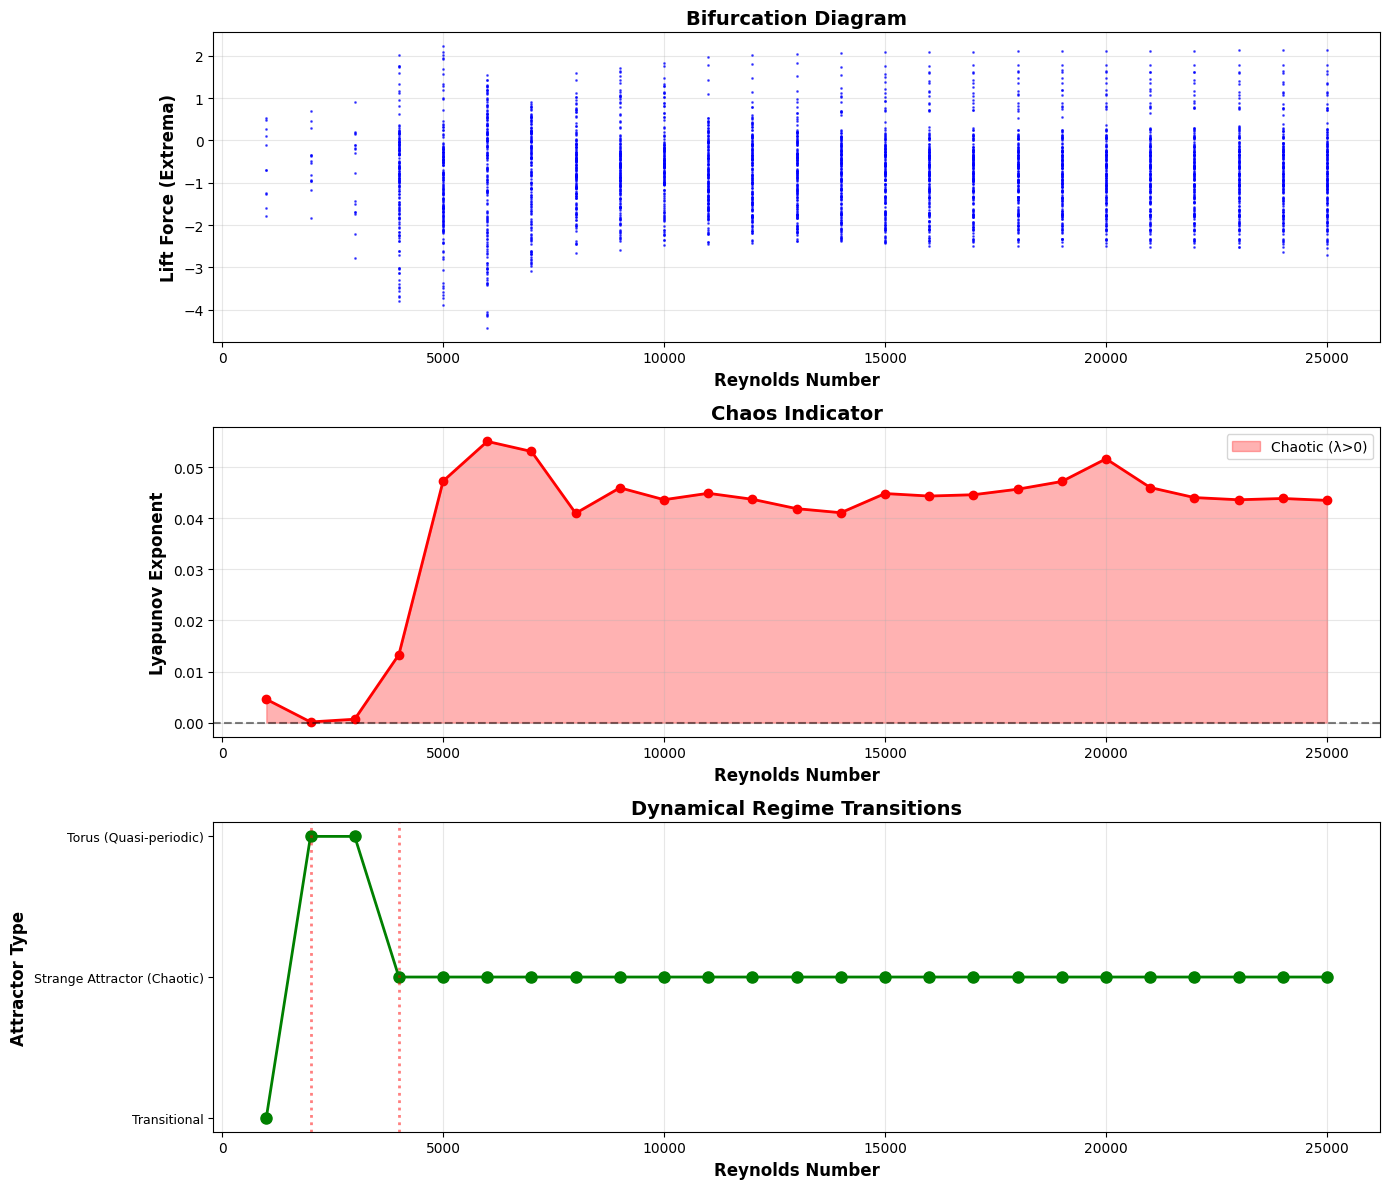


 Bifurcation diagram saved


In [5]:
if USE_BIFURCATION_MODE:
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    params = np.array([a.reynolds for a in all_analyzers])
    
    # Bifurcation diagram
    ax = axes[0]
    for analyzer in all_analyzers:
        steady_start = len(analyzer.lift_history) // 2
        lift_steady = np.array(analyzer.lift_history[steady_start:])
        peaks, _ = signal.find_peaks(lift_steady, distance=10)
        valleys, _ = signal.find_peaks(-lift_steady, distance=10)
        extrema = np.concatenate([lift_steady[peaks], lift_steady[valleys]])
        
        if len(extrema) > 0:
            ax.plot([analyzer.reynolds]*len(extrema), extrema, 'b.', markersize=2, alpha=0.6)
    
    ax.set_xlabel('Reynolds Number', fontsize=12, fontweight='bold')
    ax.set_ylabel('Lift Force (Extrema)', fontsize=12, fontweight='bold')
    ax.set_title('Bifurcation Diagram', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Lyapunov exponent
    ax = axes[1]
    lyapunovs = [a.lyapunov_exponent if a.lyapunov_exponent else 0 for a in all_analyzers]
    ax.plot(params, lyapunovs, 'ro-', linewidth=2, markersize=6)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax.fill_between(params, 0, lyapunovs, where=np.array(lyapunovs)>0, alpha=0.3, color='red', label='Chaotic (λ>0)')
    ax.set_xlabel('Reynolds Number', fontsize=12, fontweight='bold')
    ax.set_ylabel('Lyapunov Exponent', fontsize=12, fontweight='bold')
    ax.set_title('Chaos Indicator', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Attractor types
    ax = axes[2]
    attractor_types = [a.attractor_type for a in all_analyzers]
    unique_types = list(set(attractor_types))
    type_to_num = {t: i for i, t in enumerate(unique_types)}
    type_nums = [type_to_num[t] for t in attractor_types]
    
    ax.plot(params, type_nums, 'go-', linewidth=2, markersize=8)
    ax.set_yticks(range(len(unique_types)))
    ax.set_yticklabels(unique_types, fontsize=9)
    ax.set_xlabel('Reynolds Number', fontsize=12, fontweight='bold')
    ax.set_ylabel('Attractor Type', fontsize=12, fontweight='bold')
    ax.set_title('Dynamical Regime Transitions', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Mark bifurcations
    for i in range(1, len(attractor_types)):
        if attractor_types[i] != attractor_types[i-1]:
            ax.axvline(x=params[i], color='red', linestyle=':', alpha=0.5, linewidth=2)
    
    plt.tight_layout()
    plt.savefig(results_dir / "chaos" / "bifurcation_diagram.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("\n Bifurcation diagram saved")
else:
    print("\n  Skipping bifurcation diagram (not in bifurcation mode)")

## Energy Spectra Visualizations

In [6]:
print("Creating energy spectrum visualizations...\n")

for analyzer in all_analyzers:
    if len(analyzer.energy_spectra_1d) == 0:
        continue
    
    k, E_k = analyzer.energy_spectra_1d[-1]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    valid = (E_k > 0) & (k > 0.5)
    ax.loglog(k[valid], E_k[valid], 'b-', linewidth=2.5, label='Simulation')
    
    # Theoretical slopes
    k_theory = k[valid]
    if len(k_theory) > 0:
        C_kolm = E_k[valid][len(k_theory)//3] * (k_theory[len(k_theory)//3] ** (5/3))
        E_kolm = C_kolm * k_theory ** (-5/3)
        ax.loglog(k_theory, E_kolm, 'g--', linewidth=2, alpha=0.7, label='Kolmogorov $k^{-5/3}$')
        
        C_kraich = E_k[valid][len(k_theory)//3] * (k_theory[len(k_theory)//3] ** 3)
        E_kraich = C_kraich * k_theory ** (-3)
        ax.loglog(k_theory, E_kraich, 'r:', linewidth=2, alpha=0.7, label='Kraichnan $k^{-3}$')
    
    ax.set_xlabel('Wave Number $k$', fontsize=13, fontweight='bold')
    ax.set_ylabel('Energy $E(k)$', fontsize=13, fontweight='bold')
    ax.set_title(f'Energy Spectrum - Re={analyzer.reynolds:.0f}, RH={analyzer.ride_height:.0f}', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, which='both', linestyle=':')
    
    if analyzer.kolmogorov_slope:
        textstr = f'Slope: {analyzer.kolmogorov_slope:.2f}'
        ax.text(0.05, 0.05, textstr, transform=ax.transAxes, fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    filename = f"rh{analyzer.ride_height:.0f}_re{analyzer.reynolds:.0f}_spectrum.png"
    plt.savefig(results_dir / "spectra" / filename, dpi=200, bbox_inches='tight')
    plt.close()
    print(f"   {filename}")

print("\nEnergy spectra complete!")

Creating energy spectrum visualizations...

   rh19_re1000_spectrum.png
   rh19_re2000_spectrum.png
   rh19_re3000_spectrum.png
   rh19_re4000_spectrum.png
   rh19_re5000_spectrum.png
   rh19_re6000_spectrum.png
   rh19_re7000_spectrum.png
   rh19_re8000_spectrum.png
   rh19_re9000_spectrum.png
   rh19_re10000_spectrum.png
   rh19_re11000_spectrum.png
   rh19_re12000_spectrum.png
   rh19_re13000_spectrum.png
   rh19_re14000_spectrum.png
   rh19_re15000_spectrum.png
   rh19_re16000_spectrum.png
   rh19_re17000_spectrum.png
   rh19_re18000_spectrum.png
   rh19_re19000_spectrum.png
   rh19_re20000_spectrum.png
   rh19_re21000_spectrum.png
   rh19_re22000_spectrum.png
   rh19_re23000_spectrum.png
   rh19_re24000_spectrum.png
   rh19_re25000_spectrum.png

Energy spectra complete!


## Velocity + Pressure Fields

In [7]:
print("Creating velocity + pressure visualizations...\n")

for analyzer in all_analyzers:
    if len(analyzer.velocity_snapshots) == 0:
        continue
    
    velocity = analyzer.velocity_snapshots[-1]
    pressure = analyzer.pressure_snapshots[-1]
    step = analyzer.snapshot_steps[-1]
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Velocity
    ax = axes[0]
    im = ax.imshow(velocity, origin='lower', cmap='magma', vmin=0, vmax=0.15, interpolation='bilinear')
    ax.set_title(f'Velocity Field | Re={analyzer.reynolds:.0f} | Step {step}', fontsize=14, fontweight='bold')
    ax.set_xlabel('x (lattice units)', fontsize=11)
    ax.set_ylabel('y (lattice units)', fontsize=11)
    cbar = plt.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label('Velocity Magnitude |u|', fontsize=11)
    
    # Pressure
    ax = axes[1]
    vmax_p = np.nanpercentile(np.abs(pressure), 99)
    im = ax.imshow(pressure, origin='lower', cmap='RdBu_r', vmin=-vmax_p, vmax=vmax_p, interpolation='bilinear')
    ax.set_title(f'Pressure Field | Re={analyzer.reynolds:.0f} | Step {step}', fontsize=14, fontweight='bold')
    ax.set_xlabel('x (lattice units)', fontsize=11)
    ax.set_ylabel('y (lattice units)', fontsize=11)
    cbar = plt.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label('Pressure Coefficient $C_p$', fontsize=11)
    
    plt.tight_layout()
    filename = f"rh{analyzer.ride_height:.0f}_re{analyzer.reynolds:.0f}_fields.png"
    plt.savefig(results_dir / "pressure" / filename, dpi=200, bbox_inches='tight')
    plt.close()
    print(f"  {filename}")

print("\nField visualizations complete!")

Creating velocity + pressure visualizations...

  rh19_re1000_fields.png
  rh19_re2000_fields.png
  rh19_re3000_fields.png
  rh19_re4000_fields.png
  rh19_re5000_fields.png
  rh19_re6000_fields.png
  rh19_re7000_fields.png
  rh19_re8000_fields.png
  rh19_re9000_fields.png
  rh19_re10000_fields.png
  rh19_re11000_fields.png
  rh19_re12000_fields.png
  rh19_re13000_fields.png
  rh19_re14000_fields.png
  rh19_re15000_fields.png
  rh19_re16000_fields.png
  rh19_re17000_fields.png
  rh19_re18000_fields.png
  rh19_re19000_fields.png
  rh19_re20000_fields.png
  rh19_re21000_fields.png
  rh19_re22000_fields.png
  rh19_re23000_fields.png
  rh19_re24000_fields.png
  rh19_re25000_fields.png

Field visualizations complete!


## Summary Report

In [8]:
print("="*70)
print("COMPLETE ANALYSIS SUMMARY")
print("="*70)

print(f"\nTotal configurations: {len(all_analyzers)}")

# Attractor types
attractor_counts = {}
for a in all_analyzers:
    atype = a.attractor_type
    attractor_counts[atype] = attractor_counts.get(atype, 0) + 1

print(f"\nDynamical Regimes:")
for atype, count in sorted(attractor_counts.items(), key=lambda x: -x[1]):
    print(f"  • {atype}: {count} ({100*count/len(all_analyzers):.1f}%)")

# Chaos statistics
chaotic = [a for a in all_analyzers if a.lyapunov_exponent and a.lyapunov_exponent > 0.01]
print(f"\nChaotic regimes: {len(chaotic)}/{len(all_analyzers)} ({100*len(chaotic)/len(all_analyzers):.1f}%)")

if chaotic:
    max_lyap = max(a.lyapunov_exponent for a in chaotic)
    print(f"  • Maximum λ: {max_lyap:.4f}")

# Vortex shedding
shedding = [a for a in all_analyzers if a.vortex_shedding]
print(f"\nVortex shedding: {len(shedding)}/{len(all_analyzers)} cases")

# Bifurcations
if USE_BIFURCATION_MODE:
    bifurcations = []
    for i in range(1, len(all_analyzers)):
        if all_analyzers[i].attractor_type != all_analyzers[i-1].attractor_type:
            bifurcations.append((
                all_analyzers[i].reynolds,
                f"{all_analyzers[i-1].attractor_type} → {all_analyzers[i].attractor_type}"
            ))
    
    print(f"\n🔀 Bifurcations detected: {len(bifurcations)}")
    for param, transition in bifurcations:
        print(f"  • Re={param:.0f}: {transition}")

print(f"\nAll results saved to: {results_dir}")
print(f"\nGenerated outputs:")
print(f"  • {len(list((results_dir / 'spectra').glob('*.png')))} energy spectra")
print(f"  • {len(list((results_dir / 'pressure').glob('*.png')))} flow field visualizations")
print(f"  • {len(list((results_dir / 'chaos').glob('*.json')))} chaos analysis reports")
if USE_BIFURCATION_MODE:
    print(f"  • 1 bifurcation diagram")

COMPLETE ANALYSIS SUMMARY

Total configurations: 25

Dynamical Regimes:
  • Strange Attractor (Chaotic): 22 (88.0%)
  • Torus (Quasi-periodic): 2 (8.0%)
  • Transitional: 1 (4.0%)

Chaotic regimes: 22/25 (88.0%)
  • Maximum λ: 0.0550

Vortex shedding: 25/25 cases

🔀 Bifurcations detected: 2
  • Re=2000: Transitional → Torus (Quasi-periodic)
  • Re=4000: Torus (Quasi-periodic) → Strange Attractor (Chaotic)

All results saved to: complete_analysis_20260126_212404

Generated outputs:
  • 25 energy spectra
  • 25 flow field visualizations
  • 25 chaos analysis reports
  • 1 bifurcation diagram
